In [1]:
###### 

In [2]:
ENV = 'Kaggle' # VAST, Kaggle

In [3]:
# Ref:

# Blog post
# Part1: Mask-RCNN
# https://haochen23.github.io/2020/06/fine-tune-mask-rcnn-pytorch.html#.Y-2Wt-xBzUK

# Part 2: Faster-RCNN Beagle Detector
# https://haochen23.github.io/2020/06/fine-tune-faster-rcnn-pytorch.html#.Y-8k_OxBzUK

# Video by DigitalSreeni
# https://www.youtube.com/watch?v=NEl9RPyMgzY&t=28s

# TORCHVISION OBJECT DETECTION FINETUNING TUTORIAL
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

# Beagle Detector: Fine-tune Faster-RCNN
# https://haochen23.github.io/2020/06/fine-tune-faster-rcnn-pytorch.html#.Y-2VjexBzUI

In [4]:
import pandas as pd
import numpy as np
import os

import cv2

import ast

import torch
import torchvision.transforms as T
import torchvision

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch.utils.data
from PIL import Image

from tqdm import tqdm

import matplotlib.pyplot as plt

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

# Note: Pytorch uses a channels-first format:
# [batch_size, num_channels, height, width]

print(torch.__version__)
print(torchvision.__version__)

1.12.0
0.13.0


In [5]:
# Set the seed values

import random

# Set the seed value all over the place to make this reproducible.
seed_val = 101

os.environ['PYTHONHASHSEED'] = str(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.backends.cudnn.deterministic = True

In [6]:
if ENV == 'VAST':
    
    root = '/root'
    base_path = '/root/'
    data_path = '/root/df_data.csv'
    tbx11k_images_path = '/root/tbx11k-simplified/tbx11k-simplified/images/'
    pneu_comp_images_path = '/root/pneumonia-comp-proc-images/base_dir/pneu_comp/'
    covid_comp_images_path = '/root/covid-comp-proc-images/base_dir/covid_comp/'
    shen_images_path = '/root/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/'
    mont_images_path = '/root/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/'

    

if ENV == 'Kaggle':
    
    root = '/kaggle/working'
    base_path = '../input/'
    data_path = '../input/exp19-tb-prepare-the-folds/df_data.csv'
    tbx11k_images_path = '../input/tbx11k-simplified/tbx11k-simplified/images/'
    pneu_comp_images_path = '../input/pneumonia-comp-proc-images/base_dir/pneu_comp/'
    covid_comp_images_path = '../input/covid-comp-proc-images/base_dir/covid_comp/'
    shen_images_path = '../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/'
    mont_images_path = '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/'

    
print(ENV)

Kaggle


In [7]:
model_path_0 = '../input/exp103-tb-exp96-w-aug/model.pt'


In [8]:
os.listdir('../input/exp103-tb-exp96-w-aug')

['transforms.py',
 'coco_eval.py',
 '__results__.html',
 '__pycache__',
 'engine.py',
 'coco_utils.py',
 'utils.py',
 'requirements.txt',
 '__notebook__.ipynb',
 '__results___files',
 '__output__.json',
 'model.pt',
 'vision',
 'custom.css']

## Config

In [9]:
CLASS_LIST = CLASS_NAMES = ['normal','opacity']

CHOSEN_FOLD = 0

THRESHOLD = 0.5

#NUM_FOLDS = 5

NUM_EPOCHS = 10

TRAIN_BATCH_SIZE = 5
VAL_BATCH_SIZE = 1


NUM_CORES = os.cpu_count()
NUM_CORES

2

## Define the device

In [10]:
# For GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

if torch.cuda.is_available():
    print('Num GPUs:', torch.cuda.device_count())
    print('GPU Type:', torch.cuda.get_device_name(0))

cuda:0
Num GPUs: 1
GPU Type: Tesla P100-PCIE-16GB


## Load the holdout data

In [11]:
path = shen_images_path
shen_image_list = os.listdir(path)

path = mont_images_path
mont_image_list = os.listdir(path)

In [12]:
# put the images into dataframes
df_shen = pd.DataFrame(shen_image_list, columns=['image_id'])
df_mont = pd.DataFrame(mont_image_list, columns=['image_id'])

# remove the 'Thunbs.db' line
df_shen = df_shen[df_shen['image_id'] != 'Thumbs.db']
df_mont = df_mont[df_mont['image_id'] != 'Thumbs.db']

# Add a source column
df_shen['source'] = 'shen'
df_mont['source'] = 'mont'

# Reset the index or this will cause an error later
df_shen.reset_index(inplace=True, drop=True)
df_mont.reset_index(inplace=True, drop=True)

# Create a fname column
df_shen['fname'] = list(df_shen['image_id'])
df_mont['fname'] = list(df_mont['image_id'])

print(df_shen.shape)
print(df_mont.shape)

(662, 3)
(138, 3)


In [13]:
df_shen.head()

,image_id,source,fname
0,CHNCXR_0092_0.png,shen,CHNCXR_0092_0.png
1,CHNCXR_0322_0.png,shen,CHNCXR_0322_0.png
2,CHNCXR_0304_0.png,shen,CHNCXR_0304_0.png
3,CHNCXR_0572_1.png,shen,CHNCXR_0572_1.png
4,CHNCXR_0547_1.png,shen,CHNCXR_0547_1.png


In [14]:
df_mont.head()

,image_id,source,fname
0,MCUCXR_0017_0.png,mont,MCUCXR_0017_0.png
1,MCUCXR_0020_0.png,mont,MCUCXR_0020_0.png
2,MCUCXR_0030_0.png,mont,MCUCXR_0030_0.png
3,MCUCXR_0013_0.png,mont,MCUCXR_0013_0.png
4,MCUCXR_0354_1.png,mont,MCUCXR_0354_1.png


## Assign the targets

In [15]:
# Assign the targets

# Function to select the 4th index from the end of the string (file name)
# example: CHNCXR_0470_1.png --> 1 is the label, meaning TB is present.

def extract_label(x):
    
    target = int(x[-5])
    
    if target == 0:
        return 'no_tb'
    
    if target == 1:
        return 'tb'
    

# Assign the labels
df_shen['label'] = df_shen['image_id'].apply(extract_label)
df_mont['label'] = df_mont['image_id'].apply(extract_label)

In [16]:
# Shenzen Dataset

df_shen['label'].value_counts()

tb       336
no_tb    326
Name: label, dtype: int64

In [17]:
# Montgomery Dataset

df_mont['label'].value_counts()

no_tb    80
tb       58
Name: label, dtype: int64

In [18]:
# Create a binary target

def get_binary_target(x):
    
    if x == 'no_tb':
        return 0
    
    elif x == 'tb':
        return 1
    
    
# Assign the targets
df_shen['target'] = df_shen['label'].apply(get_binary_target)
df_mont['target'] = df_mont['label'].apply(get_binary_target)

In [19]:
df_shen['target'].value_counts()

1    336
0    326
Name: target, dtype: int64

In [20]:
df_mont['target'].value_counts()

0    80
1    58
Name: target, dtype: int64

## Get the path to each image

In [21]:
# Get the path to each image

def get_path(row):
    
    fname = row['fname']
    source = row['source']
    
    if source == 'shen':
        path = shen_images_path + fname
        return path
    
    elif source == 'mont':
        path = mont_images_path + fname
        return path


df_shen['orig_path'] = df_shen.apply(get_path, axis=1)
df_mont['orig_path'] = df_mont.apply(get_path, axis=1)

print(df_shen.shape)
print(df_mont.shape)

(662, 6)
(138, 6)


## Load one image

(2652, 2796, 4)


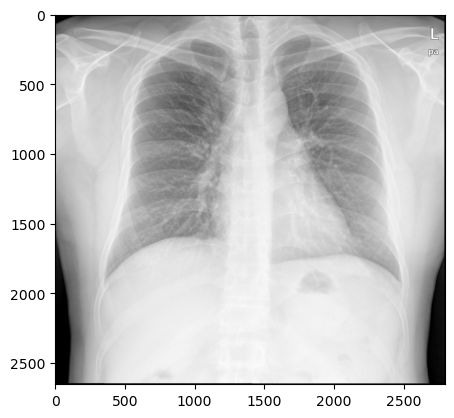

In [22]:
# Shen

i = 0
path = df_shen.loc[i, 'orig_path']
image = plt.imread(path)

print(image.shape)

plt.imshow(image)

(4020, 4892)


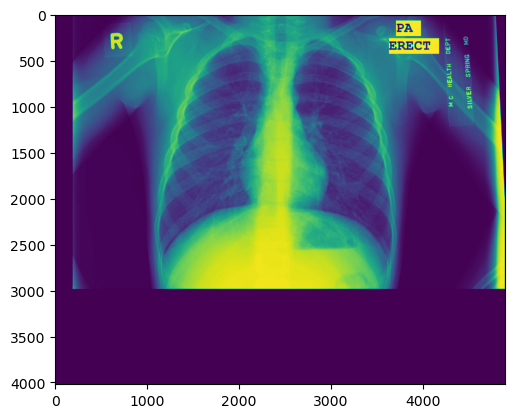

In [23]:
# Mont

i = 0
path = df_mont.loc[i, 'orig_path']
#image = plt.imread(path)
image = cv2.imread(path, cv2.IMREAD_UNCHANGED)

print(image.shape)

plt.imshow(image)

## Helper functions

In [24]:
# Confusion matrix where the size of the plot and the text size can be changed

# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                         text_size=12):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=text_size)
    plt.yticks(tick_marks, classes, fontsize=text_size)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=text_size)

    plt.ylabel('True label', fontsize=text_size)
    plt.xlabel('Predicted label', fontsize=text_size)
    plt.tight_layout()

In [25]:
def display_images(df):
    
    """
    Display jpg images in a grid.
    """
    
    plt.style.use("default")
    plt.figure(figsize=(13,12))

    rows = 5
    cols = 6

    for i in range(rows*cols):

        path = df.loc[i, 'path']
        label = df.loc[i, 'label']
        
        image = plt.imread(path)

        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        plt.title(label, color="black", fontsize=12)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [26]:
def display_images_from_batch(images):
    
    """
    Display torch tensor images from the dataloader.
    """
    
    #images = data['images']
    #targets = data['targets']
    
    plt.style.use("default")
    plt.figure(figsize=(13,12))

    rows = 1
    cols = 3

    for i in range(rows*cols):

        image = images[i]
        #label = targets[i]

        # convert from (C, H, W) to (H, W, C) format
        image = image.permute((1, 2, 0))

        # select the first channel only
        image = image[:, :, 0]

        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        #plt.title(label, color="black", fontsize=12)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [27]:
def draw_pred_bbox_on_image(image, coords_list):
    
    """
    Input:
    image: type numpy array
    coords_list: type list with format: [xmin, ymin, xmax, ymax]
    
    Output:
    image: The bbox is drawn on it.
    
    """

    xmin = int(coords_list[0])
    ymin = int(coords_list[1])
    xmax = int(coords_list[2])
    ymax = int(coords_list[3])

     # Draw the bbox on the image
    start_point = (xmin, ymin) 
    end_point = (xmax, ymax) 
    #bbox_color = (255, 255, 0)  # yellow
    bbox_color = (255, 0, 255)
    bbox_thickness = 10

    image = cv2.rectangle(image, start_point, end_point, 
                          bbox_color, bbox_thickness)
    
    return image

In [28]:
# Draw a bbox on an image

def draw_true_bbox_on_image(image, coords_dict):
    
    if coords_dict != 'none':

        coords_dict = ast.literal_eval(coords_dict)

        xmin = int(coords_dict['xmin'])
        ymin = int(coords_dict['ymin'])
        width = int(coords_dict['width'])
        height = int(coords_dict['height'])

        xmax = xmin + width
        ymax = ymin + height

         # Draw the bbox on the image
        start_point = (xmin, ymin) 
        end_point = (xmax, ymax) 
        bbox_color = (255, 255, 255)  # white
        bbox_thickness = 10

        image = cv2.rectangle(image, start_point, end_point, 
                              bbox_color, bbox_thickness)
    
    return image

In [29]:
def draw_mask_on_image(image, bool_mask):
    
    # Define a function that outputs a mask with a random colour
    def get_coloured_mask(mask):
    
        """
        Source: https://haochen23.github.io/2020/06/fine-tune-mask-rcnn-pytorch.html#.Y-3RVOxBzUL

        random_colour_masks

        """

        colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
        r = np.zeros_like(mask).astype(np.uint8)
        g = np.zeros_like(mask).astype(np.uint8)
        b = np.zeros_like(mask).astype(np.uint8)

        r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,10)]

        coloured_mask = np.stack([r, g, b], axis=2)

        return coloured_mask


    rgb_mask = get_coloured_mask(bool_mask)
    image = cv2.addWeighted(image, 1, rgb_mask, 0.5, 0)
    
    return image

In [30]:
def process_fasterrcnn_preds(pred, conf_threshold):
    
    # Get the pred scores
    pred_scores_list = list(pred[0]['scores'].detach().cpu().numpy())
    
    # Get the pred labels
    pred_labels_list = list(pred[0]['labels'].detach().cpu().numpy())
    
    # Get the pred bounding boxes, format is [[xmin, ymin, xmax, ymax], [xmin, ymin, xmax, ymax]]
    pred_boxes = pred[0]['boxes'].detach().cpu().numpy()
    pred_boxes_list = [list(item) for item in pred_boxes]
    
    fin_scores_list = []
    fin_labels_list = []
    fin_boxes_list = []
    
    if len(pred_scores_list) != 0:
        
        for i, item in enumerate(pred_scores_list):
            
            if item > conf_threshold:
                
                fin_scores_list.append(item)
                fin_labels_list.append(pred_labels_list[i])
                fin_boxes_list.append(pred_boxes_list[i])
                
    
    pred_dict = {
       'pred_scores': fin_scores_list,
        'pred_labels': fin_labels_list,
        'pred_boxes': fin_boxes_list
    }
    
    # Empty lists will be returned if the model did
    # not detect any bboxes
    return pred_dict

In [31]:
# How to pad an image to a sqaure
# We pad the right and the bottom so that if there are bbox coords
# then they won't be affected by the padding. That's because the origin for
# the coords is in the top left corner.

def pad_image_to_square(image):
    
    """
    Pads an image to a square. 
    Accepts bot grayscale and multi channel images.
    """
    
    # Get the image shape
    shape_tuple = image.shape
    
    height = image.shape[0]
    width = image.shape[1]
    
    
    # Function to pad each channel of an image to a square
    # Also pads a grayscale image to a square.
    def pad_image_channel(image_channel, height, width):

        pad_amt = abs(height - width)

        if height == width:
            pad_channel = image_channel

        elif height > width: # pad right
            top = 0
            bottom = 0
            left = 0
            right = pad_amt

            pad_channel = np.pad(image_channel, pad_width=[(top, bottom),(left, right)], mode='constant')

        else: # if width > height then pad bottom

            top = 0
            bottom = pad_amt
            left = 0
            right = 0

            pad_channel = np.pad(image_channel, pad_width=[(top, bottom),(left, right)], mode='constant')

        return pad_channel

    
    # If image is grayscale i.e. shape (height, width)
    if len(shape_tuple) == 2:
        
        # pad the image
        padded_image =  pad_image_channel(image, height, width)
    
    # If the image is not grayscale i.e. shape (height, width, num_channels)
    elif len(shape_tuple) == 3:
        
        # get the number of channels
        num_channels = image.shape[2]
        
        for j in range(0, num_channels):
            
            # select the channel
            image_channel = image[:,:,j]
            
            # pad the channels
            padded_channel =  pad_image_channel(image_channel, height, width)
            
            if j == 0:
                padded_image = padded_channel
                
            else:
                # Stack the channels along the channel axis
                padded_image = np.dstack((padded_image, padded_channel))
                
                
    return padded_image

## Prepare the images and store in a folder

In [32]:
# Create the directory structure

base_dir = 'base_dir'
os.mkdir(base_dir)

# Now we create folders inside 'base_dir':

# base_dir

    # shen
    
    # mont


shen = os.path.join(base_dir, 'shen')
os.mkdir(shen)

mont = os.path.join(base_dir, 'mont')
os.mkdir(mont)


# Display the folder structure
!tree base_dir

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
base_dir
├── mont
└── shen

2 directories, 0 files


In [33]:
# Transfer the Shen images

df_unq = df_shen.drop_duplicates('fname')
df_unq = df_unq.reset_index(drop=True)

images_path = shen_images_path
save_path = 'base_dir/shen/'

for i in tqdm(range(0, len(df_unq)), total=len(df_unq)):
    
    fname = df_unq.loc[i, 'fname']
    path = df_unq.loc[i, 'orig_path']
    
    # Load the image
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    
    # Pad the image to make it square.
    # Pad right and bottom so that the bbox coords
    # are not affected.
    image = pad_image_to_square(image)
    
    # Save the image
    new_path = save_path + fname
    
    check = cv2.imwrite(new_path, image)
    
    if check == False:
        print(f'Error. {new_fname} was not saved.')

100%|██████████| 662/662 [06:55<00:00,  1.59it/s]


In [34]:
print(len(df_unq))
print(len(os.listdir('base_dir/shen')))

662
662


(2806, 2806, 3)


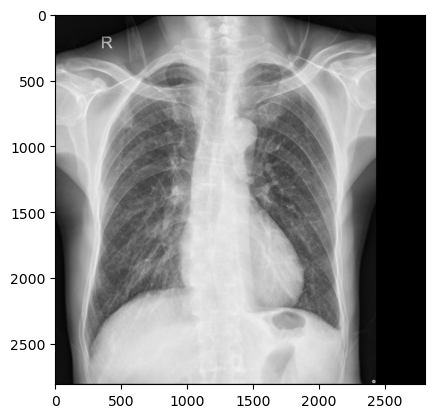

In [35]:
# Load an image to check that everything is okay

images_list = os.listdir('base_dir/shen')

fname = images_list[0]
path = 'base_dir/shen/' + fname

image = plt.imread(path)

print(image.shape)

plt.imshow(image)

In [36]:
# Transfer the Mont images

df_unq = df_mont.drop_duplicates('fname')
df_unq = df_unq.reset_index(drop=True)

images_path = mont_images_path
save_path = 'base_dir/mont/'

for i in tqdm(range(0, len(df_unq)), total=len(df_unq)):
    
    fname = df_unq.loc[i, 'fname']
    path = df_unq.loc[i, 'orig_path']
    
    # Load the image
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    
    # Pad the image to make it square.
    # Pad right and bottom so that the bbox coords
    # are not affected.
    image = pad_image_to_square(image)
    
    # Save the image
    new_path = save_path + fname
    
    check = cv2.imwrite(new_path, image)
    
    if check == False:
        print(f'Error. {new_fname} was not saved.')

100%|██████████| 138/138 [01:10<00:00,  1.95it/s]


In [37]:
print(len(df_unq))
print(len(os.listdir('base_dir/mont')))

138
138


(4892, 4892)


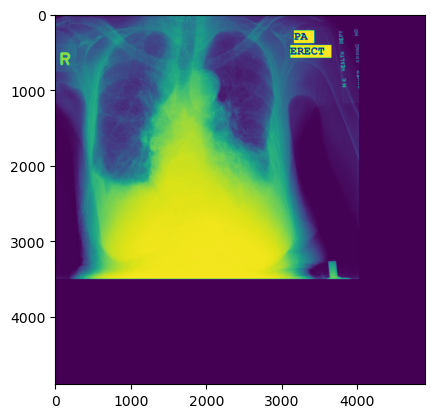

In [38]:
# Load an image to check that everything is okay

images_list = os.listdir('base_dir/mont')

fname = images_list[0]
path = 'base_dir/mont/' + fname

image = plt.imread(path)

print(image.shape)

plt.imshow(image)

## Create the new path to each image

In [39]:
# Get the path to each image

def get_path(row):
    
    fname = row['fname']
    source = row['source']
    
    if source == 'shen':
        path =  'base_dir/shen/' + fname
        return path
    
    elif source == 'mont':
        path =  'base_dir/mont/' + fname
        return path


df_shen['path'] = df_shen.apply(get_path, axis=1)
df_mont['path'] = df_mont.apply(get_path, axis=1)

print(df_shen.shape)
print(df_mont.shape)

(662, 7)
(138, 7)


## Combine the dataframes

In [40]:
# Combine the two dataframes

df_data = pd.concat([df_shen, df_mont], axis=0).reset_index(drop=True)

df_data = df_data.reset_index(drop=True)

df_data.shape

(800, 7)

## Create the val set

In [41]:
# Use the train and val sets that were defined by the dataset creators

df_val = df_data.copy()

print('Val')
print(len(df_val))
print(df_val['target'].value_counts())

Val
800
0    406
1    394
Name: target, dtype: int64


In [42]:
########################
# For testing only.

#df_val = df_val[df_val['target'] == 1]

#df_val = df_val.reset_index(drop=True)

#print(df_val.shape)

#df_val.head()

#####################

## Inference

This setup is for inference for just one image as would be done when using an app.

In [43]:
dfs = df_data[df_data['source'] == 'shen']
dfm = df_data[df_data['source'] == 'mont']

df = dfm[dfm['target'] == 1]

df.head(10)

,image_id,source,fname,label,target,orig_path,path
666,MCUCXR_0354_1.png,mont,MCUCXR_0354_1.png,tb,1,../input/pulmonary-chest-xray-abnormalities/Mo...,base_dir/mont/MCUCXR_0354_1.png
668,MCUCXR_0255_1.png,mont,MCUCXR_0255_1.png,tb,1,../input/pulmonary-chest-xray-abnormalities/Mo...,base_dir/mont/MCUCXR_0255_1.png
669,MCUCXR_0399_1.png,mont,MCUCXR_0399_1.png,tb,1,../input/pulmonary-chest-xray-abnormalities/Mo...,base_dir/mont/MCUCXR_0399_1.png
674,MCUCXR_0294_1.png,mont,MCUCXR_0294_1.png,tb,1,../input/pulmonary-chest-xray-abnormalities/Mo...,base_dir/mont/MCUCXR_0294_1.png
675,MCUCXR_0266_1.png,mont,MCUCXR_0266_1.png,tb,1,../input/pulmonary-chest-xray-abnormalities/Mo...,base_dir/mont/MCUCXR_0266_1.png
676,MCUCXR_0173_1.png,mont,MCUCXR_0173_1.png,tb,1,../input/pulmonary-chest-xray-abnormalities/Mo...,base_dir/mont/MCUCXR_0173_1.png
677,MCUCXR_0313_1.png,mont,MCUCXR_0313_1.png,tb,1,../input/pulmonary-chest-xray-abnormalities/Mo...,base_dir/mont/MCUCXR_0313_1.png
678,MCUCXR_0113_1.png,mont,MCUCXR_0113_1.png,tb,1,../input/pulmonary-chest-xray-abnormalities/Mo...,base_dir/mont/MCUCXR_0113_1.png
679,MCUCXR_0144_1.png,mont,MCUCXR_0144_1.png,tb,1,../input/pulmonary-chest-xray-abnormalities/Mo...,base_dir/mont/MCUCXR_0144_1.png
680,MCUCXR_0390_1.png,mont,MCUCXR_0390_1.png,tb,1,../input/pulmonary-chest-xray-abnormalities/Mo...,base_dir/mont/MCUCXR_0390_1.png


{'pred_scores': [0.99990356, 0.9526003, 0.9264158, 0.51098794], 'pred_labels': [3, 2, 1, 1], 'pred_boxes': [[381.73105, 444.41797, 4024.7427, 3666.3782], [0.0, 36.399033, 4892.0, 4854.8853], [3181.1382, 1022.88403, 3867.6758, 2980.8997], [3239.3218, 1079.242, 3784.1392, 2192.568]]}
MCUCXR_0266_1.png
Target: 1


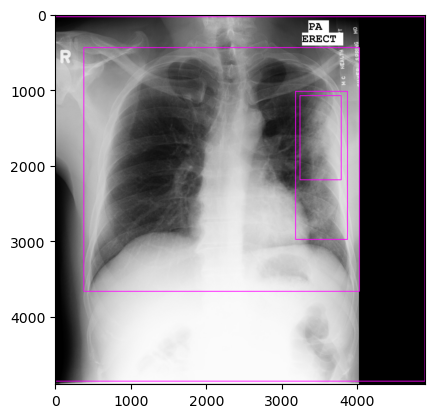

In [44]:
# Example code: Predict on one image

# Code when not using the et_prediction() function.

index = 675

# Define the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the image
path = df_val.loc[index, 'path']
target = df_val.loc[index, 'target']
#path = images_path + fname
image = Image.open(path).convert("L") #####


# Pad the image to a square

# Convert from PIL to numpy
image = np.array(image)
# Pad to square
image = pad_image_to_square(image)
# Convert back to a PIL image
image = Image.fromarray(np.uint8(image))


# Transform the image to a torch tensor.
# Note that this 'transform' comes from torchvision.
# It's not the same as the one used in the dataloader.
# The imports above are important.
my_transform = T.Compose([T.ToTensor()])
image = my_transform(image)


# Send the image to the device
image = image.to(device)

# Load the trained model
path_model = model_path_0
model = torch.load(path_model, map_location=torch.device('cpu'))

# Put the model in eval model
model.eval()

# Send the model to the device
model.to(device)

# Predict on the image
pred = model([image])

pred_dict = process_fasterrcnn_preds(pred, THRESHOLD)

print(pred_dict)


# Load the image
path = df_val.loc[index, 'path']
fname = df_val.loc[index, 'fname']
print(fname)
image = cv2.imread(path)


# Draw true bboxes on image
# -------------------------

"""
# Get the true bboxes
df_true = df_orig[df_orig['fname'] == fname]
df_true = df_true.reset_index(drop=True)
true_bbox_list = list(df_true['bbox'])

# Draw the true bboxes on the image
for bbox_coords in true_bbox_list:

    image = draw_true_bbox_on_image(image, bbox_coords)
    
"""
    
    
# Draw pred bboxes on the image
# ------------------------------

pred_boxes = pred_dict['pred_boxes']

for i in range(0, len(pred_boxes)):
    
    bbox_coords = pred_boxes[i]

    image = draw_pred_bbox_on_image(image, bbox_coords)
    
    

print(f'Target: {target}')

plt.imshow(image)
plt.show()

In [45]:
# Define the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

df_unq = df_val.drop_duplicates('fname')
df_unq = df_unq.reset_index(drop=True)

fin_pred_list = []

for i in tqdm(range(0, len(df_unq)), total=len(df_unq)):

    # Load the image
    path = df_unq.loc[i, 'path']
    #path = images_path + fname
    image = Image.open(path).convert("L") #####
    
    
    # Pad the image to a square
    
    # Convert from PIL to numpy
    image = np.array(image)
    # Pad to square
    image = pad_image_to_square(image)
    # Convert back to a PIL image
    image = Image.fromarray(np.uint8(image))
    

    # Transform the image to a torch tensor.
    # Note that this 'transform' comes from torchvision.
    # It's not the same as the one used in the dataloader.
    # The imports above are important.
    my_transform = T.Compose([T.ToTensor()])
    image = my_transform(image)


    # Send the image to the device
    image = image.to(device)

    # Load the trained model
    path_model = model_path_0
    model = torch.load(path_model, map_location=torch.device('cpu'))
    #model = torch.load(path_model)

    # Put the model in eval model
    model.eval()

    # Send the model to the device
    model.to(device)

    # Predict on the image
    pred = model([image])

    pred_dict = process_fasterrcnn_preds(pred, THRESHOLD)
    
    fin_pred_list.append(pred_dict)
    
    
# Add the preds to df_unq
df_unq['preds'] = fin_pred_list

df_unq.head()

100%|██████████| 800/800 [06:31<00:00,  2.04it/s]


,image_id,source,fname,label,target,orig_path,path,preds
0,CHNCXR_0092_0.png,shen,CHNCXR_0092_0.png,no_tb,0,../input/pulmonary-chest-xray-abnormalities/Ch...,base_dir/shen/CHNCXR_0092_0.png,"{'pred_scores': [0.9998568, 0.98899263], 'pred..."
1,CHNCXR_0322_0.png,shen,CHNCXR_0322_0.png,no_tb,0,../input/pulmonary-chest-xray-abnormalities/Ch...,base_dir/shen/CHNCXR_0322_0.png,"{'pred_scores': [0.9998254, 0.96339357], 'pred..."
2,CHNCXR_0304_0.png,shen,CHNCXR_0304_0.png,no_tb,0,../input/pulmonary-chest-xray-abnormalities/Ch...,base_dir/shen/CHNCXR_0304_0.png,"{'pred_scores': [0.99997437, 0.97586435], 'pre..."
3,CHNCXR_0572_1.png,shen,CHNCXR_0572_1.png,tb,1,../input/pulmonary-chest-xray-abnormalities/Ch...,base_dir/shen/CHNCXR_0572_1.png,"{'pred_scores': [0.999905, 0.6933127, 0.632903..."
4,CHNCXR_0547_1.png,shen,CHNCXR_0547_1.png,tb,1,../input/pulmonary-chest-xray-abnormalities/Ch...,base_dir/shen/CHNCXR_0547_1.png,"{'pred_scores': [0.9999571, 0.8193057, 0.78134..."


## Create the binary preds

In [46]:
# Get the pred target

# Note: During training the normal images were assigned class 2. That's
# why the model predicts class 2 for normal images.
# Here we will assign class 0 to normal images. This will allow us to
# compare the preds with the target column. The target column has classes 0 and 1.

# Here we will also remove class 3 preds. Class 3 refers to the lung bboxes.

def get_binary_pred(x):
    
    
    #x = ast.literal_eval(x)
    orig_pred_labels_list = x['pred_labels']
    
    assert type(orig_pred_labels_list) == list
    
    # Remove 3 from orig_pred_labels_list.
    # Target 3 is the lungs bbox
    pred_labels_list = []
    
    for item in orig_pred_labels_list:
        if item != 3:
            pred_labels_list.append(item)
            
    
    # If no labels were predicted then
    # the image is normal i.e. class 2.
    if len(pred_labels_list) == 0:
        return 0 # change class 2 to class 0
    
    # If the model predicted only one bbox
    elif len(pred_labels_list) == 1:
        
        # If the predicted label was class 2
        if pred_labels_list[0] == 2:
            return 0 # change class 2 to class 0
        else:
            return 1
        
    # The model predicted opacity bboxes.
    # Note: If a class 2 bbox was predicted in addition to
    # class 1 bboxes, we must not draw the class 2 bbox
    # on the image when showing the user the predictions.
    else:
        return 1
    
df_unq['binary_pred'] = df_unq['preds'].apply(get_binary_pred)

#df_unq.head()

In [47]:
# Check for NaN values

nan_list = list(df_unq['binary_pred'].isnull())

df_unq['nan'] = nan_list

df_unq[df_unq['nan'] == True]

,image_id,source,fname,label,target,orig_path,path,preds,binary_pred,nan


In [48]:
df_unq['target'].value_counts()

0    406
1    394
Name: target, dtype: int64

In [49]:
df_unq['binary_pred'].value_counts()

0    494
1    306
Name: binary_pred, dtype: int64

## Conf Matrix and Classif Report

In [50]:
from sklearn.metrics import confusion_matrix
import itertools
    
# targets
y_true = list(df_unq['target'])

# get the preds as integers
y_pred = list(df_unq['binary_pred'])

# argmax returns the index of the max value in each row.
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix.
print()
print(cm)
print(CLASS_LIST)


[[381  25]
 [113 281]]
['normal', 'opacity']


Confusion matrix, without normalization
[[381  25]
 [113 281]]


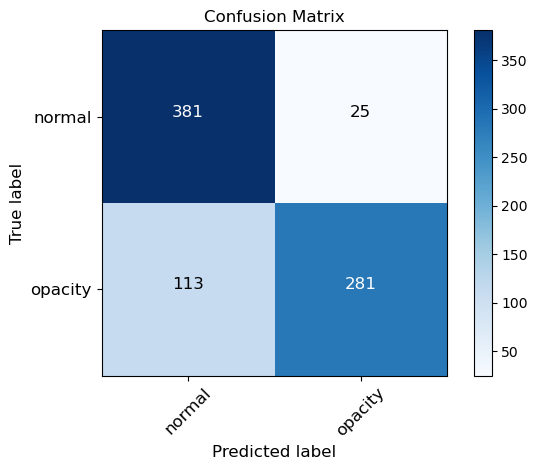

In [51]:
cm_plot_labels = CLASS_LIST

# Set the size of the plot.
#plt.figure(figsize=(10,7))

# Set the size of the text
text_size=12

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', text_size=text_size)

In [52]:
from sklearn.metrics import classification_report
    
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print()
print(report)


              precision    recall  f1-score   support

      normal       0.77      0.94      0.85       406
     opacity       0.92      0.71      0.80       394

    accuracy                           0.83       800
   macro avg       0.84      0.83      0.82       800
weighted avg       0.84      0.83      0.83       800



In [53]:
# Create a requirements.txt file
# This is a list of all packages and their versions that were 
# used to create this solution.

!pip freeze > requirements.txt

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [54]:
!ls

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
__notebook__.ipynb  base_dir  requirements.txt
